In [56]:
# Import libraries and methods/functions
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

## Demographics Dataset

In [57]:
demo = pd.read_csv('telecom_demographics.csv')
print(demo.head())

   customer_id telecom_partner gender  age             state       city  \
0        15169          Airtel      F   26  Himachal Pradesh      Delhi   
1       149207          Airtel      F   74       Uttarakhand  Hyderabad   
2       148119          Airtel      F   54         Jharkhand    Chennai   
3       187288    Reliance Jio      M   29             Bihar  Hyderabad   
4        14016        Vodafone      M   45          Nagaland  Bangalore   

   pincode registration_event  num_dependents  estimated_salary  
0   667173         2020-03-16               4             85979  
1   313997         2022-01-16               0             69445  
2   549925         2022-01-11               2             75949  
3   230636         2022-07-26               3             34272  
4   188036         2020-03-11               4             34157  


## Telecom Usage Dataset

In [58]:
usage = pd.read_csv('telecom_usage.csv')
print(usage.head())

   customer_id  calls_made  sms_sent  data_used  churn
0        15169          75        21       4532      1
1       149207          35        38        723      1
2       148119          70        47       4688      1
3       187288          95        32      10241      1
4        14016          66        23       5246      1


To analyze the full list of features available for churned customers, we'll merge the dataframes on the shared customer id.

In [59]:
churn_df = demo.merge(usage, on='customer_id')
print(churn_df.head())

   customer_id telecom_partner gender  age             state       city  \
0        15169          Airtel      F   26  Himachal Pradesh      Delhi   
1       149207          Airtel      F   74       Uttarakhand  Hyderabad   
2       148119          Airtel      F   54         Jharkhand    Chennai   
3       187288    Reliance Jio      M   29             Bihar  Hyderabad   
4        14016        Vodafone      M   45          Nagaland  Bangalore   

   pincode registration_event  num_dependents  estimated_salary  calls_made  \
0   667173         2020-03-16               4             85979          75   
1   313997         2022-01-16               0             69445          35   
2   549925         2022-01-11               2             75949          70   
3   230636         2022-07-26               3             34272          95   
4   188036         2020-03-11               4             34157          66   

   sms_sent  data_used  churn  
0        21       4532      1  
1        3

We'll next describe and inspect the merged dataframe.

In [60]:
print(churn_df.info())
print(churn_df.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6500 entries, 0 to 6499
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   customer_id         6500 non-null   int64 
 1   telecom_partner     6500 non-null   object
 2   gender              6500 non-null   object
 3   age                 6500 non-null   int64 
 4   state               6500 non-null   object
 5   city                6500 non-null   object
 6   pincode             6500 non-null   int64 
 7   registration_event  6500 non-null   object
 8   num_dependents      6500 non-null   int64 
 9   estimated_salary    6500 non-null   int64 
 10  calls_made          6500 non-null   int64 
 11  sms_sent            6500 non-null   int64 
 12  data_used           6500 non-null   int64 
 13  churn               6500 non-null   int64 
dtypes: int64(9), object(5)
memory usage: 761.7+ KB
None
         customer_id          age        pincode  num_dependents  \


We can see that there are no missing values in the dataset. However, there are negative values in the calls_made, sms_sent, and data_used columns, which is improbable.

In [61]:
neg_cols = ['calls_made', 'sms_sent', 'data_used']

neg_values = churn_df[churn_df[neg_cols] < 0].any(axis=1)
print(neg_values.sum())

494


494 rows contain invalid data. These rows have been dropped.

In [62]:
churn_df_no_neg = churn_df[~neg_values]
print(churn_df_no_neg.describe())

         customer_id          age        pincode  num_dependents  \
count    6006.000000  6006.000000    6006.000000     6006.000000   
mean   121293.031968    45.999334  549732.513487        1.981352   
std     70298.899930    16.402951  259947.265743        1.403808   
min        47.000000    18.000000  100045.000000        0.000000   
25%     60411.250000    32.000000  322094.500000        1.000000   
50%    120490.000000    46.000000  551589.000000        2.000000   
75%    181683.750000    60.000000  776290.000000        3.000000   
max    243505.000000    74.000000  999740.000000        4.000000   

       estimated_salary   calls_made     sms_sent     data_used        churn  
count       6006.000000  6006.000000  6006.000000   6006.000000  6006.000000  
mean       85710.897602    51.184316    24.892607   5130.820180     0.198635  
std        37561.812626    28.783347    14.199986   2846.166545     0.399006  
min        20001.000000     0.000000     0.000000      7.000000     0.0

If we had the date that the customer churned, we could use the registration date to identify how long a churned customer lasted with a company before churning. However, without this data, using the registration date in the model is not beneficial. A customer could have registered 10 years ago and churned the next day. Their 10-year *tenure* value is not representative of their actual tenure. Therefore, registration_date is being removed from the dataset.

In [63]:
#churn_df_no_neg = churn_df_no_neg.drop(columns=['registration_event'])

It was previously observed that there are 5 categorical columns: telecom_partner, gender, state, city, and registration_event. These are one-hot encoded using pd.get_dummies to prepare them for a classification model.

In [64]:
churn_df_onehot = pd.get_dummies(churn_df_no_neg, columns=['telecom_partner', 'gender', 'state', 'city', 'registration_event'])
print(churn_df_onehot.head())

   customer_id  age  pincode  num_dependents  estimated_salary  calls_made  \
0        15169   26   667173               4             85979          75   
1       149207   74   313997               0             69445          35   
2       148119   54   549925               2             75949          70   
3       187288   29   230636               3             34272          95   
4        14016   45   188036               4             34157          66   

   sms_sent  data_used  churn  telecom_partner_Airtel  ...  \
0        21       4532      1                       1  ...   
1        38        723      1                       1  ...   
2        47       4688      1                       1  ...   
3        32      10241      1                       0  ...   
4        23       5246      1                       0  ...   

   registration_event_2023-04-24  registration_event_2023-04-25  \
0                              0                              0   
1                       

Now that the dataset is ready, we establish our features, scale the features, split the sets, and begin modeling.

In [65]:
features = churn_df_onehot.drop(columns=['customer_id', 'churn'], axis=1)
target = churn_df_onehot['churn']

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

This project is interested to know whether the Random Forest or Logistic Regression classifier performs better, so we will only instantiate those two models. Our scoring metric will be the accuracy score.

In [66]:
# Logistic Regression
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)
logreg_pred = logreg.predict(X_test)

# Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

We'll create and plot the confusion matrix, and use it to determine the accuracy.

## Logistic Regression

0.6946755407653911


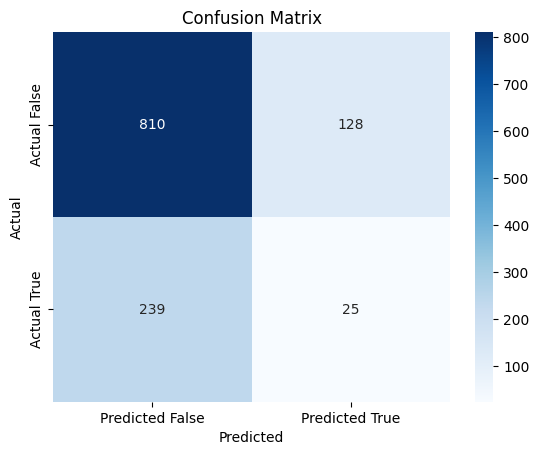

In [67]:
lr_conf_matrix = confusion_matrix(y_test, logreg_pred)
logreg_acc = (lr_conf_matrix[0,0] + lr_conf_matrix[1,1]) / (lr_conf_matrix[0,0] + lr_conf_matrix[1,1] + lr_conf_matrix[0,1] + lr_conf_matrix[1,0])
print(logreg_acc)

sns.heatmap(lr_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted False', 'Predicted True'], yticklabels=['Actual False', 'Actual True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Random Forest Classifier

0.7778702163061564


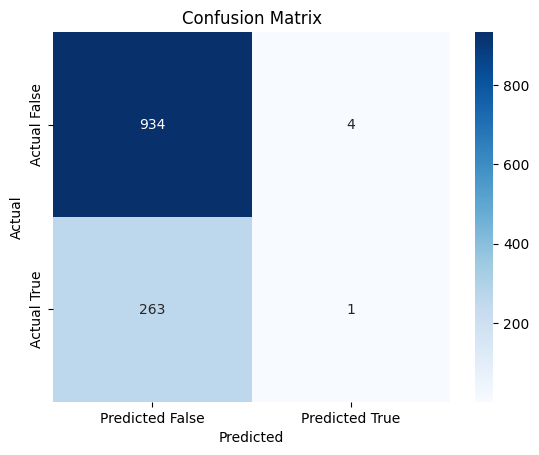

In [68]:
rf_conf_matrix = confusion_matrix(y_test, rf_pred)
rf_acc = (rf_conf_matrix[0,0] + rf_conf_matrix[1,1]) / (rf_conf_matrix[0,0] + rf_conf_matrix[1,1] + rf_conf_matrix[0,1] + rf_conf_matrix[1,0])
print(rf_acc)

sns.heatmap(rf_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted False', 'Predicted True'], yticklabels=['Actual False', 'Actual True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Results
The Random Forest Classifier has a higher accuracy score, suggesting that it performs better. Looking at the confusion matrix, it's important to consider the business context behind predicting customer churn. This model almost exclusively predicted that customers would not churn. This might be desired if the cost of retention is extremely high. However, we might be more interested to identify a customer that will churn at the expense of additional false positives. This is typically the case with churn models, so accuracy is likely a poor metric to utilize for this business case. We might be better served to gauge the performance of the model using recall.